# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

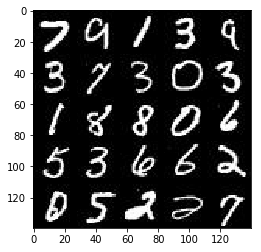

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

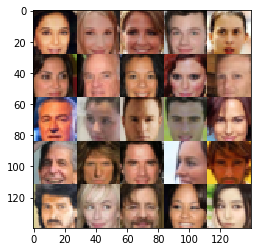

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real,  inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [18]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        conv0 = tf.layers.conv2d(images, 16, 4, strides=2, padding='same')
        relu0 = tf.maximum(alpha * conv0, conv0)
        
        conv1 = tf.layers.conv2d(conv0, 32, 4, strides=2, padding="same")
        bnor1 = tf.layers.batch_normalization(conv1, training=True)
        maxi1 = tf.maximum(alpha * bnor1, bnor1)

        conv2 = tf.layers.conv2d(maxi1, 64, 4, strides=2, padding="same")
        bnor2 = tf.layers.batch_normalization(conv2, training=True)
        maxi2 = tf.maximum(alpha * bnor2, bnor2)

        conv3 = tf.layers.conv2d(maxi2, 128, 4, strides=2, padding="same")
        bnor3 = tf.layers.batch_normalization(conv3, training=True)
        maxi3 = tf.maximum(alpha * bnor3, bnor3)

        flat = tf.reshape(maxi3, (-1, 2*2*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [19]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    reuse=not is_train
    with tf.variable_scope('generator', reuse=reuse):

        dens1 = tf.layers.dense(z, 2*2*128)

        resh1 = tf.reshape(dens1, (-1, 2, 2, 128))
        bnor1 = tf.layers.batch_normalization(resh1, training=is_train)
        maxi1 = tf.maximum(alpha * bnor1, bnor1)

        conv2 = tf.layers.conv2d_transpose(maxi1, 64, 4, strides=2, padding='same')
        bnor2 = tf.layers.batch_normalization(conv2, training=is_train)
        maxi2 = tf.maximum(alpha * bnor2, bnor2)

        conv3 = tf.layers.conv2d_transpose(maxi2, 32, 4, strides=1, padding='valid')
        bnor3 = tf.layers.batch_normalization(conv3, training=is_train)
        maxi3 = tf.maximum(alpha * bnor3, bnor3)

        conv4 = tf.layers.conv2d_transpose(maxi3, 16, 4, strides=2, padding='same')
        bnor4 = tf.layers.batch_normalization(conv4, training=is_train)
        maxi4 = tf.maximum(alpha * bnor4, bnor4)

        logits = tf.layers.conv2d_transpose(maxi4, out_channel_dim, 4, strides=2, padding='same')

        out = tf.tanh(logits)
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [ ]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0 
    print_every = 20
    show_every = 100 
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                steps += 1

                # Sample random noise for the Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                #Optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
    print("Done!")

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.0660... Generator Loss: 0.2130
Epoch 1/2... Discriminator Loss: 1.9914... Generator Loss: 0.2082
Epoch 1/2... Discriminator Loss: 1.7358... Generator Loss: 0.2485
Epoch 1/2... Discriminator Loss: 0.6805... Generator Loss: 1.5622
Epoch 1/2... Discriminator Loss: 1.0665... Generator Loss: 0.6573


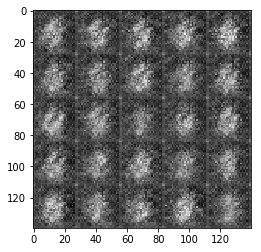

Epoch 1/2... Discriminator Loss: 1.0018... Generator Loss: 0.7052
Epoch 1/2... Discriminator Loss: 0.8363... Generator Loss: 2.2465
Epoch 1/2... Discriminator Loss: 0.7060... Generator Loss: 1.7186
Epoch 1/2... Discriminator Loss: 1.0281... Generator Loss: 0.6698
Epoch 1/2... Discriminator Loss: 1.0728... Generator Loss: 1.5914


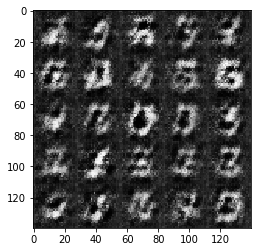

Epoch 1/2... Discriminator Loss: 0.7953... Generator Loss: 0.9783
Epoch 1/2... Discriminator Loss: 0.9028... Generator Loss: 0.7044
Epoch 1/2... Discriminator Loss: 0.6690... Generator Loss: 1.5268
Epoch 1/2... Discriminator Loss: 0.6427... Generator Loss: 1.2760
Epoch 1/2... Discriminator Loss: 1.1486... Generator Loss: 0.6635


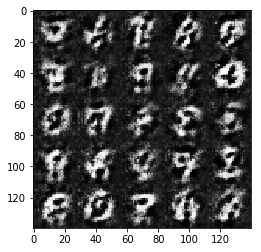

Epoch 1/2... Discriminator Loss: 0.8535... Generator Loss: 0.8034
Epoch 1/2... Discriminator Loss: 0.9723... Generator Loss: 0.6495
Epoch 1/2... Discriminator Loss: 0.7377... Generator Loss: 0.9405
Epoch 1/2... Discriminator Loss: 0.7094... Generator Loss: 2.0594
Epoch 1/2... Discriminator Loss: 0.6719... Generator Loss: 1.3661


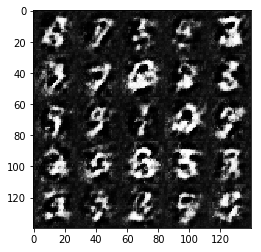

Epoch 1/2... Discriminator Loss: 0.9222... Generator Loss: 0.6546
Epoch 1/2... Discriminator Loss: 0.8536... Generator Loss: 1.0254
Epoch 1/2... Discriminator Loss: 0.9296... Generator Loss: 0.7374
Epoch 1/2... Discriminator Loss: 0.7957... Generator Loss: 1.0857
Epoch 1/2... Discriminator Loss: 1.0921... Generator Loss: 2.5399


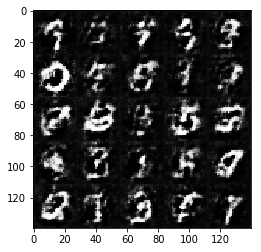

Epoch 1/2... Discriminator Loss: 0.7103... Generator Loss: 1.2210
Epoch 1/2... Discriminator Loss: 0.6140... Generator Loss: 1.6074
Epoch 1/2... Discriminator Loss: 0.6611... Generator Loss: 1.3826
Epoch 1/2... Discriminator Loss: 0.7153... Generator Loss: 1.5591
Epoch 1/2... Discriminator Loss: 0.9163... Generator Loss: 0.6928


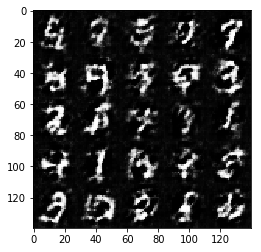

Epoch 1/2... Discriminator Loss: 1.4659... Generator Loss: 0.3070
Epoch 1/2... Discriminator Loss: 0.9215... Generator Loss: 0.6422
Epoch 1/2... Discriminator Loss: 0.9661... Generator Loss: 0.6159
Epoch 1/2... Discriminator Loss: 1.1303... Generator Loss: 0.5091
Epoch 1/2... Discriminator Loss: 0.7963... Generator Loss: 1.2650


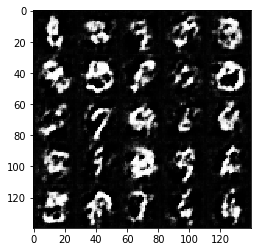

Epoch 1/2... Discriminator Loss: 0.9880... Generator Loss: 0.7823
Epoch 1/2... Discriminator Loss: 0.6606... Generator Loss: 1.9827
Epoch 1/2... Discriminator Loss: 0.7381... Generator Loss: 1.2451
Epoch 1/2... Discriminator Loss: 0.8609... Generator Loss: 0.7355
Epoch 1/2... Discriminator Loss: 1.0757... Generator Loss: 0.5769


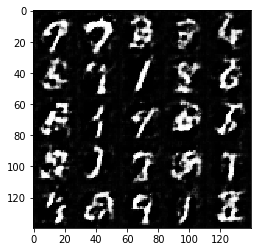

Epoch 1/2... Discriminator Loss: 0.6843... Generator Loss: 1.1580
Epoch 1/2... Discriminator Loss: 1.2593... Generator Loss: 0.4291
Epoch 1/2... Discriminator Loss: 0.7655... Generator Loss: 1.1003
Epoch 1/2... Discriminator Loss: 0.7868... Generator Loss: 1.3087
Epoch 1/2... Discriminator Loss: 1.2730... Generator Loss: 0.4033


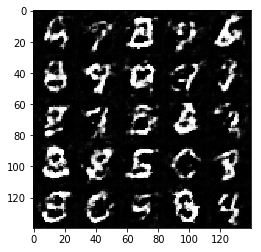

Epoch 1/2... Discriminator Loss: 0.9488... Generator Loss: 0.6708
Epoch 1/2... Discriminator Loss: 0.7898... Generator Loss: 1.8118
Epoch 1/2... Discriminator Loss: 1.0181... Generator Loss: 0.6402
Epoch 1/2... Discriminator Loss: 0.9988... Generator Loss: 0.7210
Epoch 1/2... Discriminator Loss: 1.0127... Generator Loss: 0.6986


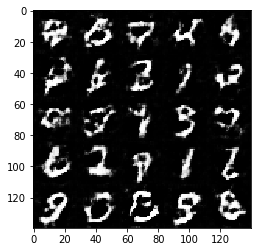

Epoch 1/2... Discriminator Loss: 0.7077... Generator Loss: 1.2027
Epoch 1/2... Discriminator Loss: 0.9702... Generator Loss: 0.7237
Epoch 1/2... Discriminator Loss: 0.8390... Generator Loss: 0.9454
Epoch 1/2... Discriminator Loss: 1.1212... Generator Loss: 0.5237
Epoch 1/2... Discriminator Loss: 1.4443... Generator Loss: 0.3391


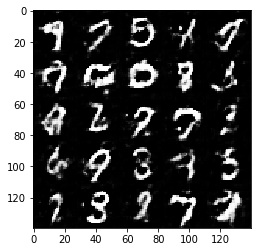

Epoch 1/2... Discriminator Loss: 0.8210... Generator Loss: 1.7446
Epoch 1/2... Discriminator Loss: 0.8646... Generator Loss: 1.7485
Epoch 1/2... Discriminator Loss: 1.0731... Generator Loss: 0.6370
Epoch 1/2... Discriminator Loss: 0.7656... Generator Loss: 1.4432
Epoch 1/2... Discriminator Loss: 0.9568... Generator Loss: 0.8051


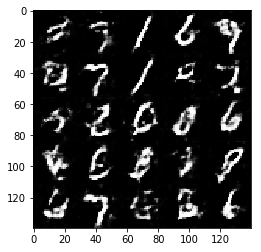

Epoch 1/2... Discriminator Loss: 1.0258... Generator Loss: 0.6380
Epoch 1/2... Discriminator Loss: 0.6889... Generator Loss: 1.2345
Epoch 1/2... Discriminator Loss: 1.1640... Generator Loss: 0.4695
Epoch 1/2... Discriminator Loss: 0.9939... Generator Loss: 0.6110
Epoch 1/2... Discriminator Loss: 1.0706... Generator Loss: 0.5660


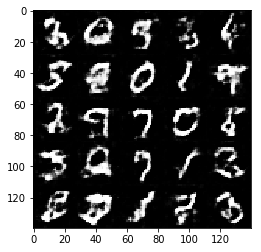

Epoch 1/2... Discriminator Loss: 0.8739... Generator Loss: 0.9510
Epoch 1/2... Discriminator Loss: 0.9241... Generator Loss: 0.7837
Epoch 1/2... Discriminator Loss: 1.3827... Generator Loss: 0.4507
Epoch 1/2... Discriminator Loss: 1.4236... Generator Loss: 0.3725
Epoch 1/2... Discriminator Loss: 1.1118... Generator Loss: 0.5583


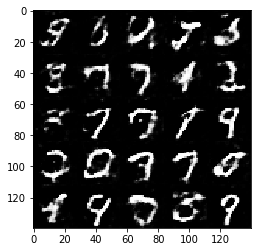

Epoch 1/2... Discriminator Loss: 1.4831... Generator Loss: 0.3279
Epoch 1/2... Discriminator Loss: 0.9456... Generator Loss: 0.6321
Epoch 1/2... Discriminator Loss: 1.0853... Generator Loss: 0.5626
Epoch 1/2... Discriminator Loss: 1.0922... Generator Loss: 1.5188
Epoch 1/2... Discriminator Loss: 1.4977... Generator Loss: 0.3377


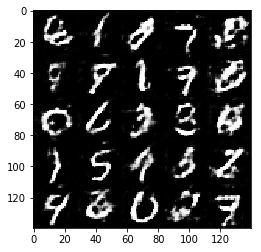

Epoch 1/2... Discriminator Loss: 1.0126... Generator Loss: 0.6709
Epoch 1/2... Discriminator Loss: 1.0975... Generator Loss: 0.5285
Epoch 1/2... Discriminator Loss: 0.9000... Generator Loss: 0.7789
Epoch 1/2... Discriminator Loss: 1.0301... Generator Loss: 1.1612
Epoch 1/2... Discriminator Loss: 0.9897... Generator Loss: 0.7326


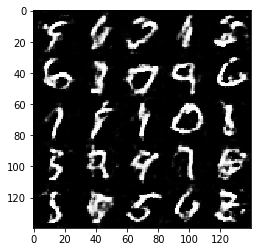

Epoch 1/2... Discriminator Loss: 0.8271... Generator Loss: 0.8895
Epoch 1/2... Discriminator Loss: 0.8338... Generator Loss: 1.1604
Epoch 1/2... Discriminator Loss: 1.1970... Generator Loss: 0.4998
Epoch 1/2... Discriminator Loss: 0.7103... Generator Loss: 1.0794
Epoch 1/2... Discriminator Loss: 0.7806... Generator Loss: 1.2511


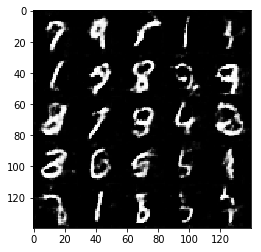

Epoch 1/2... Discriminator Loss: 0.6506... Generator Loss: 1.5108
Epoch 1/2... Discriminator Loss: 1.0505... Generator Loss: 0.5801
Epoch 1/2... Discriminator Loss: 0.8230... Generator Loss: 1.0813
Epoch 1/2... Discriminator Loss: 0.8620... Generator Loss: 1.5859
Epoch 1/2... Discriminator Loss: 1.1868... Generator Loss: 0.5196


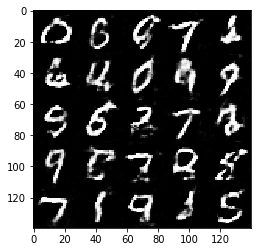

Epoch 1/2... Discriminator Loss: 0.7461... Generator Loss: 0.9707
Epoch 1/2... Discriminator Loss: 0.8145... Generator Loss: 0.9679
Epoch 1/2... Discriminator Loss: 1.1743... Generator Loss: 0.4892
Epoch 2/2... Discriminator Loss: 0.7416... Generator Loss: 1.5994
Epoch 2/2... Discriminator Loss: 0.9122... Generator Loss: 0.7863


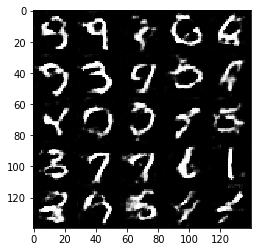

Epoch 2/2... Discriminator Loss: 0.9567... Generator Loss: 0.6637
Epoch 2/2... Discriminator Loss: 0.7982... Generator Loss: 1.2549
Epoch 2/2... Discriminator Loss: 0.9155... Generator Loss: 0.6641
Epoch 2/2... Discriminator Loss: 0.8845... Generator Loss: 1.3897
Epoch 2/2... Discriminator Loss: 0.9247... Generator Loss: 0.7413


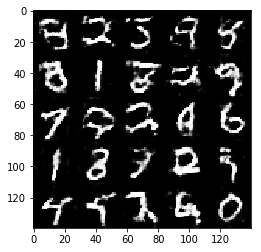

Epoch 2/2... Discriminator Loss: 1.4916... Generator Loss: 2.7938
Epoch 2/2... Discriminator Loss: 0.7114... Generator Loss: 0.9645
Epoch 2/2... Discriminator Loss: 0.8986... Generator Loss: 0.8442
Epoch 2/2... Discriminator Loss: 0.7100... Generator Loss: 1.4014
Epoch 2/2... Discriminator Loss: 1.5133... Generator Loss: 0.3230


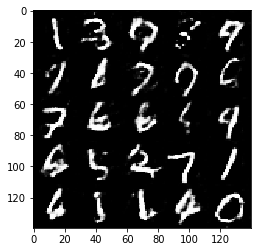

Epoch 2/2... Discriminator Loss: 1.0744... Generator Loss: 0.6305
Epoch 2/2... Discriminator Loss: 0.9670... Generator Loss: 0.7290
Epoch 2/2... Discriminator Loss: 0.9199... Generator Loss: 0.8760
Epoch 2/2... Discriminator Loss: 0.7936... Generator Loss: 0.9444
Epoch 2/2... Discriminator Loss: 1.6760... Generator Loss: 0.2577


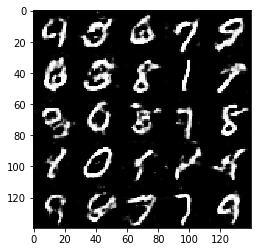

Epoch 2/2... Discriminator Loss: 1.0238... Generator Loss: 0.8033
Epoch 2/2... Discriminator Loss: 0.7813... Generator Loss: 0.9989
Epoch 2/2... Discriminator Loss: 1.0214... Generator Loss: 0.6769
Epoch 2/2... Discriminator Loss: 0.7937... Generator Loss: 1.5105
Epoch 2/2... Discriminator Loss: 1.3445... Generator Loss: 0.4218


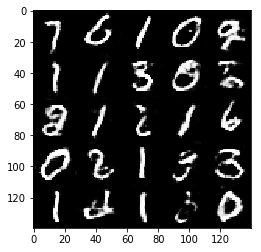

Epoch 2/2... Discriminator Loss: 0.8066... Generator Loss: 1.3729
Epoch 2/2... Discriminator Loss: 0.9115... Generator Loss: 0.8627
Epoch 2/2... Discriminator Loss: 0.8860... Generator Loss: 1.1217
Epoch 2/2... Discriminator Loss: 0.8872... Generator Loss: 1.2017
Epoch 2/2... Discriminator Loss: 1.1700... Generator Loss: 0.5394


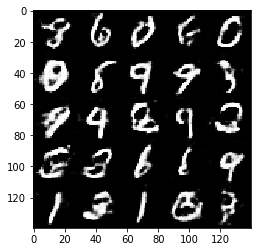

Epoch 2/2... Discriminator Loss: 0.8765... Generator Loss: 1.5627
Epoch 2/2... Discriminator Loss: 1.5113... Generator Loss: 0.3410
Epoch 2/2... Discriminator Loss: 0.6710... Generator Loss: 1.4813
Epoch 2/2... Discriminator Loss: 0.9104... Generator Loss: 1.1089
Epoch 2/2... Discriminator Loss: 1.0277... Generator Loss: 0.8175


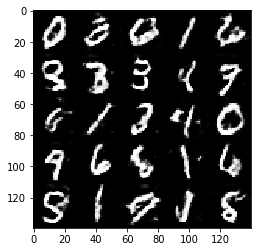

Epoch 2/2... Discriminator Loss: 0.6883... Generator Loss: 1.1176
Epoch 2/2... Discriminator Loss: 0.8208... Generator Loss: 0.9351
Epoch 2/2... Discriminator Loss: 0.9456... Generator Loss: 0.7386
Epoch 2/2... Discriminator Loss: 1.3238... Generator Loss: 0.4127
Epoch 2/2... Discriminator Loss: 0.8830... Generator Loss: 1.4385


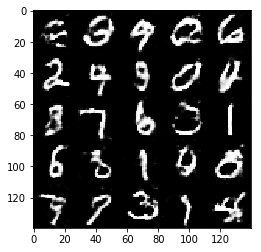

Epoch 2/2... Discriminator Loss: 0.8588... Generator Loss: 0.7554
Epoch 2/2... Discriminator Loss: 0.5996... Generator Loss: 1.6837
Epoch 2/2... Discriminator Loss: 0.6395... Generator Loss: 1.3339
Epoch 2/2... Discriminator Loss: 0.9303... Generator Loss: 0.9764
Epoch 2/2... Discriminator Loss: 0.8234... Generator Loss: 0.9636


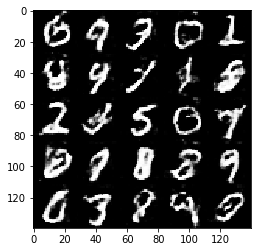

Epoch 2/2... Discriminator Loss: 1.6756... Generator Loss: 0.2565
Epoch 2/2... Discriminator Loss: 0.6715... Generator Loss: 1.0978
Epoch 2/2... Discriminator Loss: 1.0379... Generator Loss: 0.6816
Epoch 2/2... Discriminator Loss: 0.7712... Generator Loss: 0.9327
Epoch 2/2... Discriminator Loss: 0.8521... Generator Loss: 0.8329


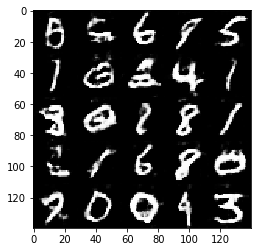

Epoch 2/2... Discriminator Loss: 0.7397... Generator Loss: 1.2236
Epoch 2/2... Discriminator Loss: 1.0579... Generator Loss: 0.6204
Epoch 2/2... Discriminator Loss: 0.6374... Generator Loss: 1.5170
Epoch 2/2... Discriminator Loss: 1.4083... Generator Loss: 0.4284
Epoch 2/2... Discriminator Loss: 0.9171... Generator Loss: 0.7605


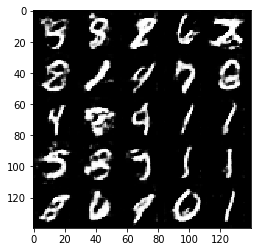

Epoch 2/2... Discriminator Loss: 0.9981... Generator Loss: 0.6220
Epoch 2/2... Discriminator Loss: 0.9477... Generator Loss: 0.6771
Epoch 2/2... Discriminator Loss: 0.7284... Generator Loss: 1.4285
Epoch 2/2... Discriminator Loss: 0.9692... Generator Loss: 1.0821
Epoch 2/2... Discriminator Loss: 0.8366... Generator Loss: 0.9308


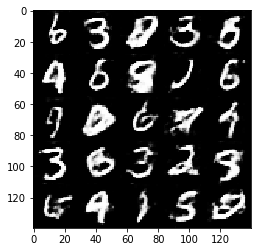

Epoch 2/2... Discriminator Loss: 1.2282... Generator Loss: 0.4837
Epoch 2/2... Discriminator Loss: 0.6614... Generator Loss: 1.7032
Epoch 2/2... Discriminator Loss: 0.5735... Generator Loss: 1.5797
Epoch 2/2... Discriminator Loss: 0.8641... Generator Loss: 0.7505
Epoch 2/2... Discriminator Loss: 0.7546... Generator Loss: 1.0611


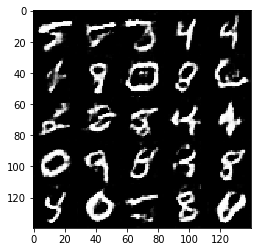

Epoch 2/2... Discriminator Loss: 1.2262... Generator Loss: 0.4945
Epoch 2/2... Discriminator Loss: 0.7969... Generator Loss: 0.9084
Epoch 2/2... Discriminator Loss: 0.9379... Generator Loss: 0.7505
Epoch 2/2... Discriminator Loss: 0.7260... Generator Loss: 1.6179
Epoch 2/2... Discriminator Loss: 0.8099... Generator Loss: 0.9844


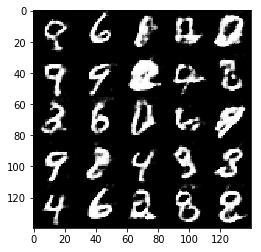

Epoch 2/2... Discriminator Loss: 0.9891... Generator Loss: 0.6149
Epoch 2/2... Discriminator Loss: 0.8121... Generator Loss: 0.9279
Epoch 2/2... Discriminator Loss: 1.0370... Generator Loss: 0.5559
Epoch 2/2... Discriminator Loss: 0.7880... Generator Loss: 1.2369
Epoch 2/2... Discriminator Loss: 0.8822... Generator Loss: 0.6766


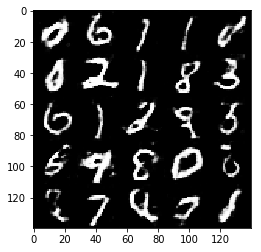

Epoch 2/2... Discriminator Loss: 0.6920... Generator Loss: 1.1362
Epoch 2/2... Discriminator Loss: 1.0219... Generator Loss: 0.6154
Epoch 2/2... Discriminator Loss: 1.1806... Generator Loss: 0.4958
Epoch 2/2... Discriminator Loss: 0.7864... Generator Loss: 1.6183
Epoch 2/2... Discriminator Loss: 0.8420... Generator Loss: 0.7774


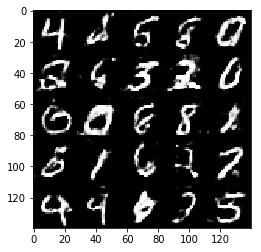

Epoch 2/2... Discriminator Loss: 0.6639... Generator Loss: 1.1941
Epoch 2/2... Discriminator Loss: 0.7398... Generator Loss: 0.9577
Epoch 2/2... Discriminator Loss: 0.6321... Generator Loss: 1.1069
Epoch 2/2... Discriminator Loss: 0.7061... Generator Loss: 1.6542
Epoch 2/2... Discriminator Loss: 1.0575... Generator Loss: 0.6097


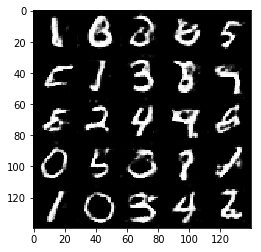

Epoch 2/2... Discriminator Loss: 0.8522... Generator Loss: 0.7805
Epoch 2/2... Discriminator Loss: 0.7679... Generator Loss: 1.2836
Epoch 2/2... Discriminator Loss: 0.7952... Generator Loss: 1.2125
Epoch 2/2... Discriminator Loss: 0.6286... Generator Loss: 1.2252
Epoch 2/2... Discriminator Loss: 0.6671... Generator Loss: 1.2559


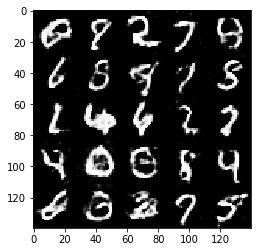

Epoch 2/2... Discriminator Loss: 1.0276... Generator Loss: 0.6047
Epoch 2/2... Discriminator Loss: 1.2076... Generator Loss: 0.4612
Epoch 2/2... Discriminator Loss: 0.9225... Generator Loss: 0.7453
Epoch 2/2... Discriminator Loss: 1.2544... Generator Loss: 0.4518
Epoch 2/2... Discriminator Loss: 1.1691... Generator Loss: 0.5686


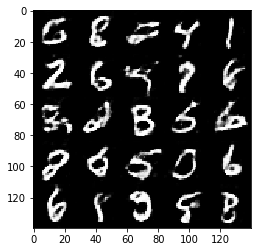

Epoch 2/2... Discriminator Loss: 1.6149... Generator Loss: 0.3537
Epoch 2/2... Discriminator Loss: 1.2752... Generator Loss: 0.4768
Done!


In [20]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2831... Generator Loss: 2.6964
Epoch 1/1... Discriminator Loss: 1.8170... Generator Loss: 0.2560
Epoch 1/1... Discriminator Loss: 0.4346... Generator Loss: 1.5551
Epoch 1/1... Discriminator Loss: 0.4823... Generator Loss: 1.3095
Epoch 1/1... Discriminator Loss: 0.5941... Generator Loss: 0.9626


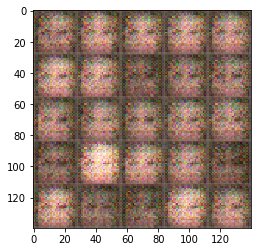

Epoch 1/1... Discriminator Loss: 0.3460... Generator Loss: 1.7300
Epoch 1/1... Discriminator Loss: 0.3729... Generator Loss: 2.3552
Epoch 1/1... Discriminator Loss: 0.8230... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 0.6926... Generator Loss: 0.9309
Epoch 1/1... Discriminator Loss: 0.6322... Generator Loss: 1.1393


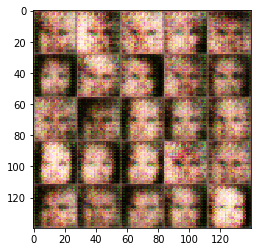

Epoch 1/1... Discriminator Loss: 0.9650... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 0.5375
Epoch 1/1... Discriminator Loss: 0.5184... Generator Loss: 1.6740
Epoch 1/1... Discriminator Loss: 0.6669... Generator Loss: 2.4741
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.4683


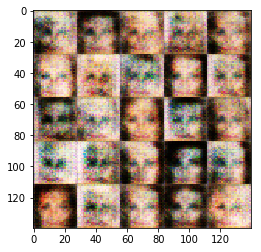

Epoch 1/1... Discriminator Loss: 0.6554... Generator Loss: 1.4833
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.4952
Epoch 1/1... Discriminator Loss: 1.5332... Generator Loss: 0.3077
Epoch 1/1... Discriminator Loss: 0.6219... Generator Loss: 1.8729
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 0.6190


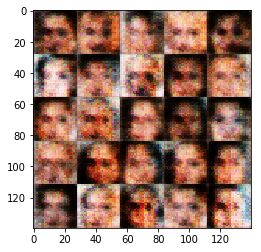

Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 1.1055
Epoch 1/1... Discriminator Loss: 0.9651... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 0.6012... Generator Loss: 1.3280
Epoch 1/1... Discriminator Loss: 0.8991... Generator Loss: 2.3481
Epoch 1/1... Discriminator Loss: 0.7337... Generator Loss: 1.7419


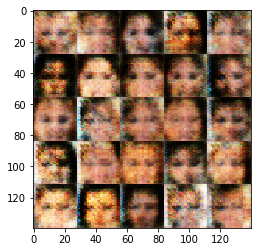

Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.4091
Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 2.9236
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 0.9696
Epoch 1/1... Discriminator Loss: 0.8862... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 0.7633... Generator Loss: 0.9490


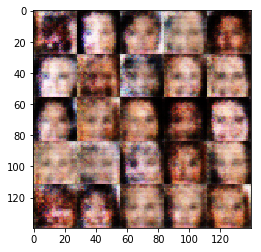

Epoch 1/1... Discriminator Loss: 0.7005... Generator Loss: 1.1046
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 1.9734
Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 1.3844
Epoch 1/1... Discriminator Loss: 0.8708... Generator Loss: 1.2074
Epoch 1/1... Discriminator Loss: 0.6639... Generator Loss: 1.1305


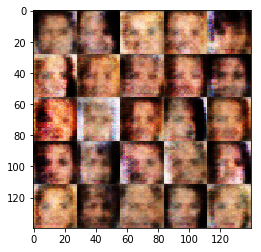

Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 0.5736
Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 0.8078... Generator Loss: 1.5795
Epoch 1/1... Discriminator Loss: 0.8234... Generator Loss: 1.5829
Epoch 1/1... Discriminator Loss: 0.8535... Generator Loss: 1.1021


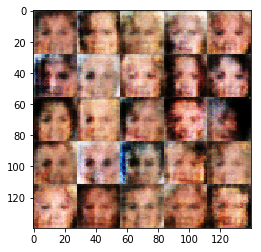

Epoch 1/1... Discriminator Loss: 0.8380... Generator Loss: 1.0038
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 1.0826
Epoch 1/1... Discriminator Loss: 0.8774... Generator Loss: 1.1315
Epoch 1/1... Discriminator Loss: 1.0066... Generator Loss: 0.7163


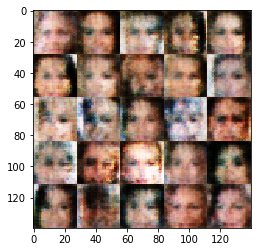

Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 1.7818
Epoch 1/1... Discriminator Loss: 0.9080... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 0.8574... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 0.5884


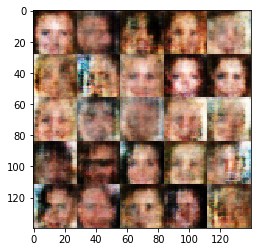

Epoch 1/1... Discriminator Loss: 0.9204... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 1.1178
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.3468
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.4876
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 0.9481


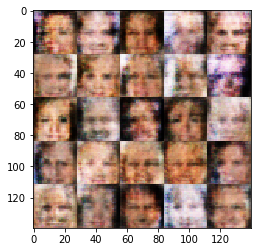

Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 1.8766
Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 1.5252
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 0.9435
Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 0.9733


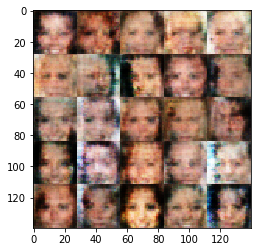

Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 1.1906
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 0.9556... Generator Loss: 0.9451


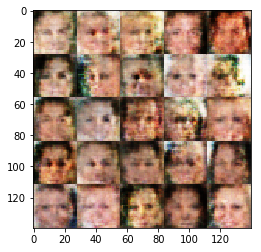

Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.4649
Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 0.8465... Generator Loss: 0.9779


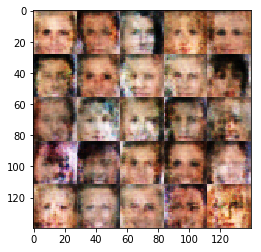

Epoch 1/1... Discriminator Loss: 1.0236... Generator Loss: 1.4850
Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 0.6922


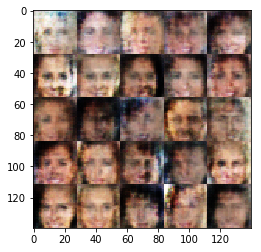

Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 0.7599


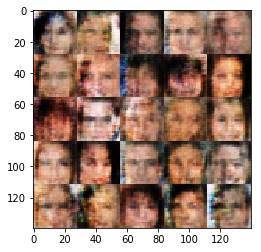

Epoch 1/1... Discriminator Loss: 0.8972... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 0.8389... Generator Loss: 1.0730
Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 1.3515


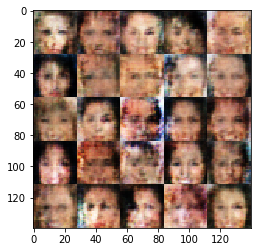

Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.4568
Epoch 1/1... Discriminator Loss: 0.8910... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 0.8980... Generator Loss: 0.9523
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.4624
Epoch 1/1... Discriminator Loss: 0.8551... Generator Loss: 1.0651


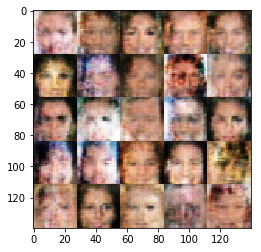

Epoch 1/1... Discriminator Loss: 0.9142... Generator Loss: 0.8942
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 0.8468... Generator Loss: 1.1700
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.3243
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.5276


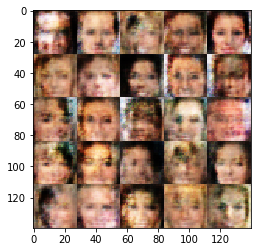

Epoch 1/1... Discriminator Loss: 0.9424... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 0.8793... Generator Loss: 0.9196
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 0.8068... Generator Loss: 1.0991
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.4427


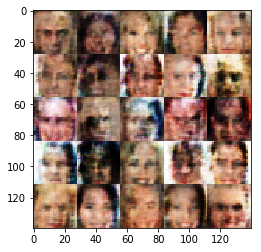

Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 0.8273... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 0.8985... Generator Loss: 0.8781
Epoch 1/1... Discriminator Loss: 0.9411... Generator Loss: 1.3971


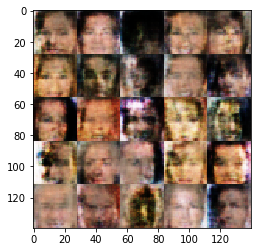

Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.4274
Epoch 1/1... Discriminator Loss: 1.0139... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 0.8281... Generator Loss: 0.9772
Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.4282


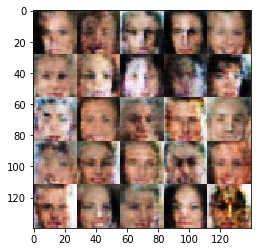

Epoch 1/1... Discriminator Loss: 0.9040... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 0.7594... Generator Loss: 1.0091
Epoch 1/1... Discriminator Loss: 0.9150... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 0.8276


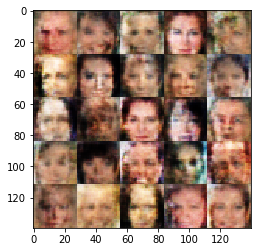

Epoch 1/1... Discriminator Loss: 0.8964... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 0.9053... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 0.9991... Generator Loss: 1.2676
Epoch 1/1... Discriminator Loss: 0.9366... Generator Loss: 1.0104
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.4363


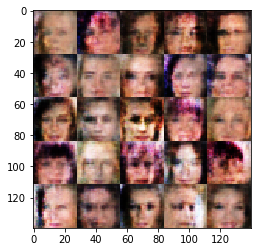

Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 0.8903... Generator Loss: 1.3999
Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 0.8499


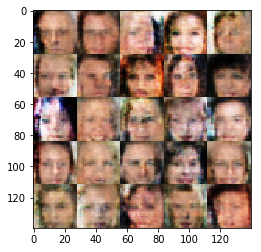

Epoch 1/1... Discriminator Loss: 0.8567... Generator Loss: 1.3981
Epoch 1/1... Discriminator Loss: 0.7923... Generator Loss: 1.4335
Epoch 1/1... Discriminator Loss: 0.8231... Generator Loss: 0.9480
Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 0.8655... Generator Loss: 1.1068


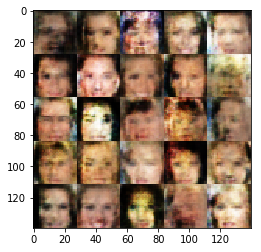

Epoch 1/1... Discriminator Loss: 0.7227... Generator Loss: 1.3321
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.4389
Epoch 1/1... Discriminator Loss: 1.5413... Generator Loss: 0.3024


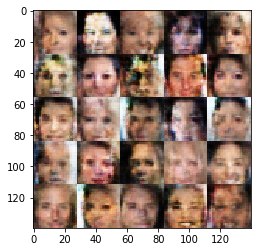

Epoch 1/1... Discriminator Loss: 0.9046... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 0.9820... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 0.6318... Generator Loss: 1.6857


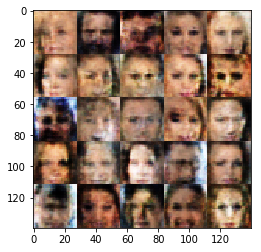

Epoch 1/1... Discriminator Loss: 0.9138... Generator Loss: 1.4533
Epoch 1/1... Discriminator Loss: 0.6110... Generator Loss: 1.2380
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.5314
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.5160
Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 0.8459


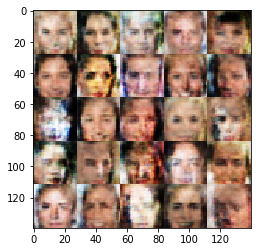

Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.4748
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 1.6272
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.3563
Epoch 1/1... Discriminator Loss: 0.8609... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.8286... Generator Loss: 0.2281


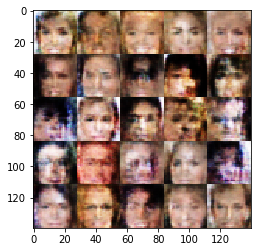

Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 0.5478
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.4297
Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 0.9121... Generator Loss: 0.7372


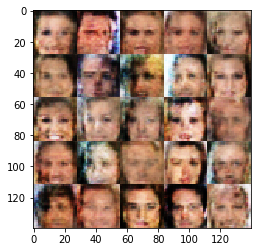

Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.3817
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 0.5852
Epoch 1/1... Discriminator Loss: 0.9109... Generator Loss: 0.8540
Epoch 1/1... Discriminator Loss: 0.8180... Generator Loss: 0.9578
Epoch 1/1... Discriminator Loss: 0.8219... Generator Loss: 1.2227


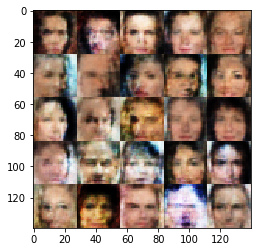

Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.4343
Epoch 1/1... Discriminator Loss: 1.8009... Generator Loss: 0.2336
Epoch 1/1... Discriminator Loss: 0.9078... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.3904


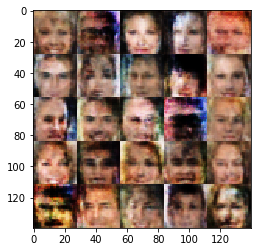

Epoch 1/1... Discriminator Loss: 0.8582... Generator Loss: 1.1265
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 0.7411... Generator Loss: 1.5945
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.5093
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 0.7445


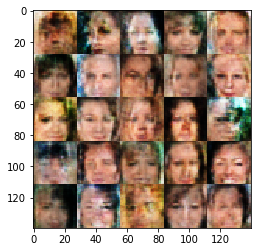

Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 0.6813... Generator Loss: 1.9555
Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 0.4716
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 0.6095


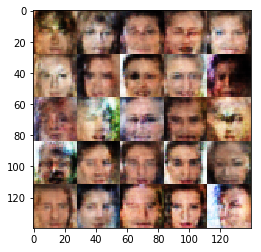

Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 0.5291
Epoch 1/1... Discriminator Loss: 0.8450... Generator Loss: 1.1149
Epoch 1/1... Discriminator Loss: 0.8774... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 0.7256... Generator Loss: 1.1407


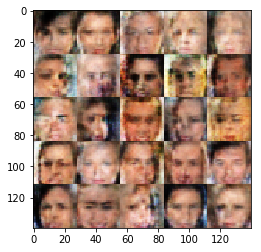

Epoch 1/1... Discriminator Loss: 0.6102... Generator Loss: 1.5194
Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 0.5012... Generator Loss: 1.3959
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 0.7538


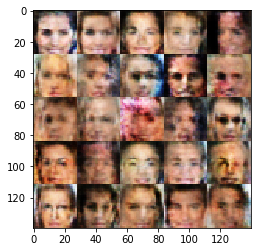

Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.5557
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.4913
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 0.5796
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.3906


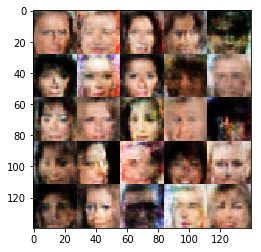

Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 1.5703
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.4448
Epoch 1/1... Discriminator Loss: 0.8661... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 1.6799
Epoch 1/1... Discriminator Loss: 0.8763... Generator Loss: 0.8893


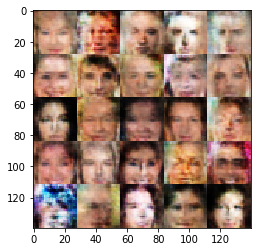

Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 0.7434... Generator Loss: 1.5941
Epoch 1/1... Discriminator Loss: 0.7889... Generator Loss: 0.9524
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 0.5768
Epoch 1/1... Discriminator Loss: 0.9129... Generator Loss: 1.6636


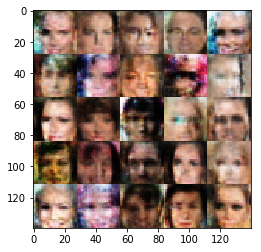

Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.4798
Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 0.9514
Epoch 1/1... Discriminator Loss: 0.8153... Generator Loss: 0.9242
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 0.5797


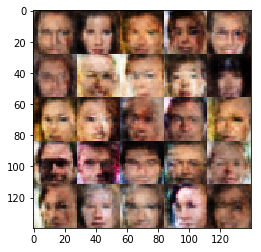

Epoch 1/1... Discriminator Loss: 0.8461... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 1.9741
Epoch 1/1... Discriminator Loss: 1.0161... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 0.8702... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 0.8013... Generator Loss: 1.9824


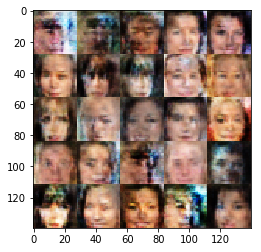

Epoch 1/1... Discriminator Loss: 0.7280... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 0.8026... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 0.8514... Generator Loss: 1.0204
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.3973
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 0.6318


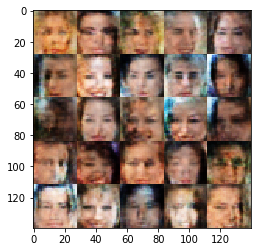

Epoch 1/1... Discriminator Loss: 0.8787... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.5363... Generator Loss: 0.3164
Epoch 1/1... Discriminator Loss: 0.7163... Generator Loss: 1.7947


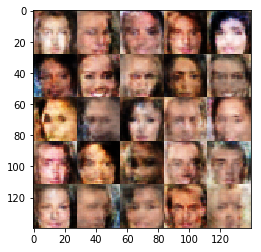

Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.4837
Epoch 1/1... Discriminator Loss: 1.6240... Generator Loss: 0.3222
Epoch 1/1... Discriminator Loss: 0.8307... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 0.5736
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.4368


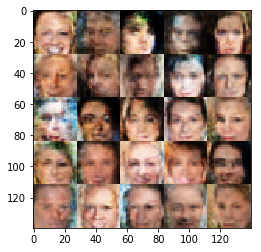

Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 2.3233
Epoch 1/1... Discriminator Loss: 0.5561... Generator Loss: 1.9872
Epoch 1/1... Discriminator Loss: 0.8501... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 0.7817... Generator Loss: 0.9852


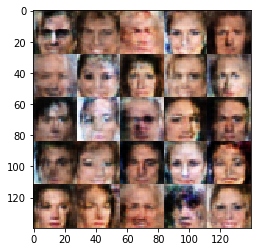

Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 0.5893
Epoch 1/1... Discriminator Loss: 0.6610... Generator Loss: 1.2728
Epoch 1/1... Discriminator Loss: 0.7867... Generator Loss: 0.9518
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 0.5513
Epoch 1/1... Discriminator Loss: 0.7793... Generator Loss: 1.8027


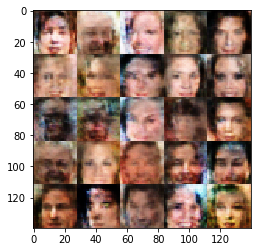

Epoch 1/1... Discriminator Loss: 0.9708... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 0.6137... Generator Loss: 1.2332
Epoch 1/1... Discriminator Loss: 0.8596... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 0.7749... Generator Loss: 1.2704


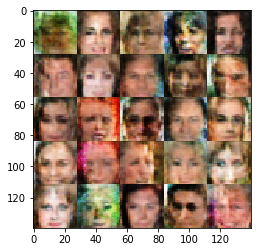

Epoch 1/1... Discriminator Loss: 0.7323... Generator Loss: 1.6457
Epoch 1/1... Discriminator Loss: 0.9442... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 0.9082... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 0.7566... Generator Loss: 1.4622


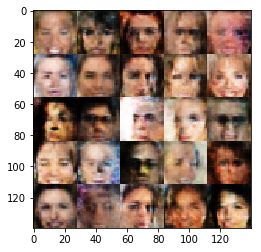

Epoch 1/1... Discriminator Loss: 0.6005... Generator Loss: 1.6962
Epoch 1/1... Discriminator Loss: 0.8284... Generator Loss: 1.0752
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.4876
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.4236
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 0.6086


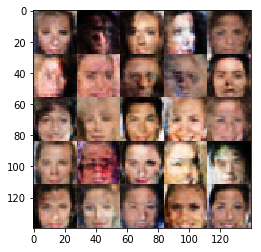

Epoch 1/1... Discriminator Loss: 0.8555... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 0.5139
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 0.5530
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.4017
Epoch 1/1... Discriminator Loss: 0.9302... Generator Loss: 0.7821


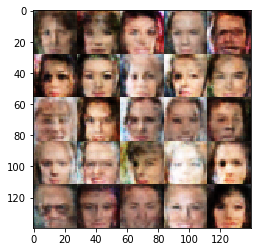

Epoch 1/1... Discriminator Loss: 0.9070... Generator Loss: 1.1811
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.3931
Epoch 1/1... Discriminator Loss: 0.8412... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.3282
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.5818


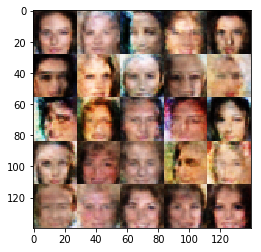

Epoch 1/1... Discriminator Loss: 0.8002... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 0.8629... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.0171... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 0.9195... Generator Loss: 0.6722


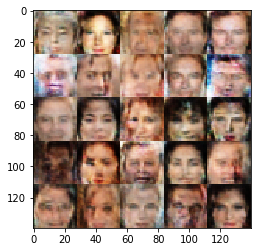

Epoch 1/1... Discriminator Loss: 0.7086... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.4943
Epoch 1/1... Discriminator Loss: 0.7275... Generator Loss: 1.1853
Epoch 1/1... Discriminator Loss: 0.9218... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 0.6216


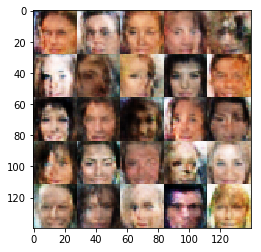

Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 0.5378
Epoch 1/1... Discriminator Loss: 0.4916... Generator Loss: 1.7475
Epoch 1/1... Discriminator Loss: 0.5675... Generator Loss: 1.5824
Epoch 1/1... Discriminator Loss: 0.7047... Generator Loss: 2.1688
Epoch 1/1... Discriminator Loss: 0.9224... Generator Loss: 0.6835


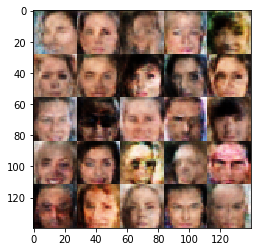

Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.3184
Epoch 1/1... Discriminator Loss: 1.5047... Generator Loss: 0.3178
Epoch 1/1... Discriminator Loss: 0.6843... Generator Loss: 1.9050
Epoch 1/1... Discriminator Loss: 0.6805... Generator Loss: 1.9536
Epoch 1/1... Discriminator Loss: 0.9317... Generator Loss: 0.9901


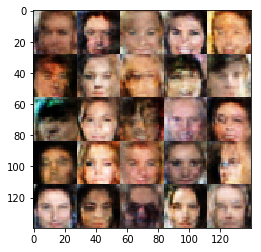

Epoch 1/1... Discriminator Loss: 0.6829... Generator Loss: 1.2432
Epoch 1/1... Discriminator Loss: 0.6338... Generator Loss: 1.2613
Epoch 1/1... Discriminator Loss: 1.8718... Generator Loss: 0.2286
Epoch 1/1... Discriminator Loss: 0.8266... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 0.8871... Generator Loss: 0.7327


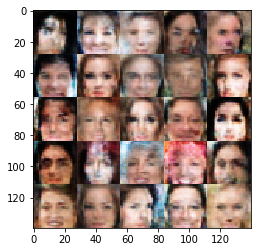

Epoch 1/1... Discriminator Loss: 0.7341... Generator Loss: 1.0034
Epoch 1/1... Discriminator Loss: 0.6582... Generator Loss: 1.4259
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 0.5522
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 0.5795
Epoch 1/1... Discriminator Loss: 0.8862... Generator Loss: 0.7100


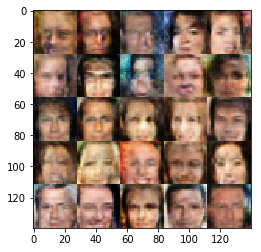

Epoch 1/1... Discriminator Loss: 0.7637... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 0.8255... Generator Loss: 1.4146
Epoch 1/1... Discriminator Loss: 0.6104... Generator Loss: 1.5847
Epoch 1/1... Discriminator Loss: 0.7896... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 0.7674... Generator Loss: 1.1208


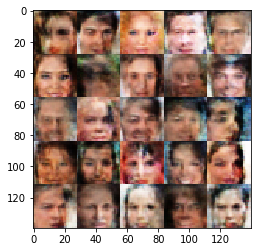

Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 0.4775
Epoch 1/1... Discriminator Loss: 0.9819... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 0.8208... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 0.8102... Generator Loss: 1.8425
Epoch 1/1... Discriminator Loss: 0.9766... Generator Loss: 0.7691


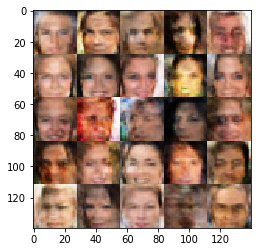

Epoch 1/1... Discriminator Loss: 0.8801... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 0.7919... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 0.7404... Generator Loss: 0.9913
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.5149


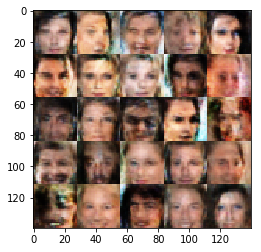

Epoch 1/1... Discriminator Loss: 0.8776... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 1.2963
Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 2.2662


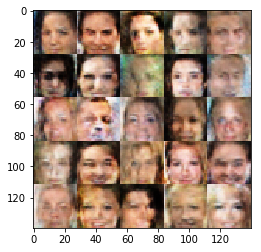

Epoch 1/1... Discriminator Loss: 0.9897... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 0.6138... Generator Loss: 2.0725
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 0.5633... Generator Loss: 2.0073
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 0.6392


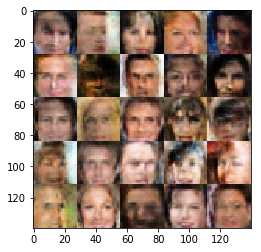

Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.4440
Done!


In [22]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.